# Model clinical trajectories from longitudinal data
* **Input:** 
    1. Clinical data - csv / tables    


* **functions**
    1. Generate trajectory templates
    2. Assign trajectory labels to new subjects


* **user parameters**
    1. Number of timepoints for modeling
    2. Number of clusters (post-hoc) 

In [1]:
# Basic lib imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import collections
from scipy import stats
import seaborn as sns
import pickle
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

In [136]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
def get_clusters(df,feat_cols,n_clusters, plot_clusters, permute):
    # Returns orginal dataframe with cluster assignments
    # Returns percentage overlap of clusters for each permuted sample
    
    if plot_clusters:
        g = sns.clustermap(df[feat_cols], row_cluster=True, col_cluster=False, metric = 'euclidean', method='ward', 
                           xticklabels=True, yticklabels=False)    
        
    Z = sch.linkage(pdist(df[feat_cols]), metric ='euclidean',method='ward')
    #Z2 = g.dendrogram_row.linkage #same as above but from sns.clustermap handle
    
    T = sch.fcluster(Z, n_clusters, 'maxclust')      
    df['T'] = T
    
    #Stability 
    if permute:    
        permute_ci = []
        for p in range(permute):                     
            # Create two samples
            df_samp_1 = df.sample(frac=0.8)            
            df_samp_2 = df.sample(frac=0.8)     
            sub_samp_1 = df_samp_1['sub'].values
            sub_samp_2 = df_samp_2['sub'].values            
            
            # Generate two permuted solutions
            Z_samp = sch.linkage(pdist(df_samp_1[feat_cols]), metric ='euclidean',method='ward')
            T_samp_1 = sch.fcluster(Z_samp, n_clusters, 'maxclust')      
            Z_samp = sch.linkage(pdist(df_samp_2[feat_cols]), metric ='euclidean',method='ward')            
            T_samp_2 = sch.fcluster(Z_samp, n_clusters, 'maxclust')      
            
            #Find overlap between subjects that belong to same cluster
            cluster_intersect = []
            for c1 in range(1,n_clusters+1):
                ci = [] 
                for c2 in range(1,n_clusters+1): #Compare with every cluster from second permuted sample
                    ci.append(len(set(sub_samp_1[T_samp_1==c1])&set(sub_samp_2[T_samp_2==c2])))
                
                #Since cluster number/name have no particular order, 
                # we are looking for maximum overlap between each cluster solution
                cluster_intersect.append(np.max(ci))
                
            # Fraction of subjects maintained their cluster membership in a permuted sample
            permute_ci.append(np.sum(cluster_intersect)/len(df_samp_1))
            
    return df, permute_ci


/data/chamal/projects/nikhil/code/python/conda/anaconda2/envs/tensorflow_v14/lib/python3.5/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/data/chamal/projects/nikhil/code/python/conda/anaconda2/envs/tensorflow_v14/lib/python3.5/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/data/chamal/projects/nikhil/code/python/conda/anaconda2/envs/tensorflow_v14/lib/python3.5/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/data/chamal/projects/nikhil/code/python/conda/anaconda2/envs/tensorflow_v14/lib/python3.5/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks(

Text(139.922,0.5,'pair-wise stability')

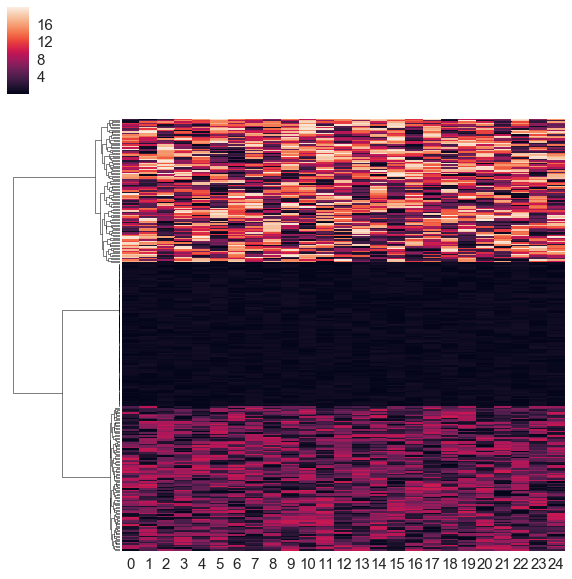

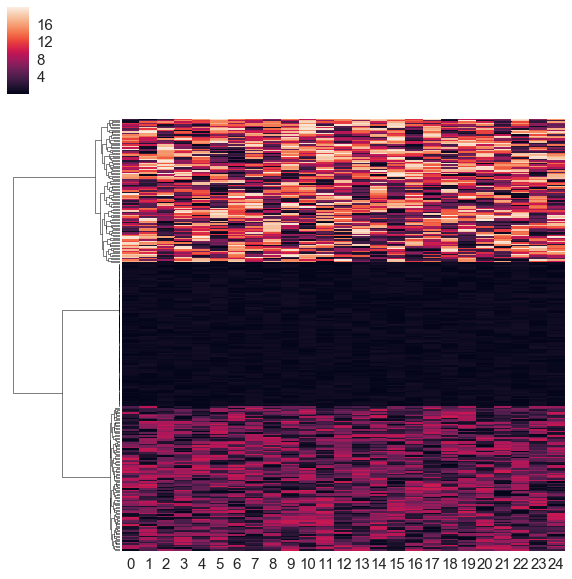

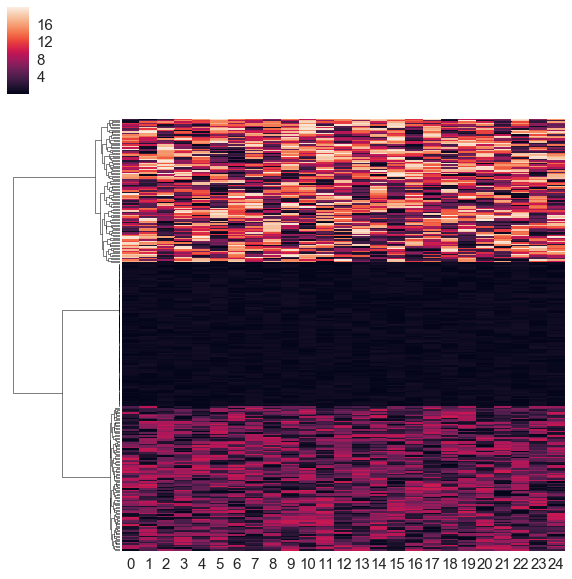

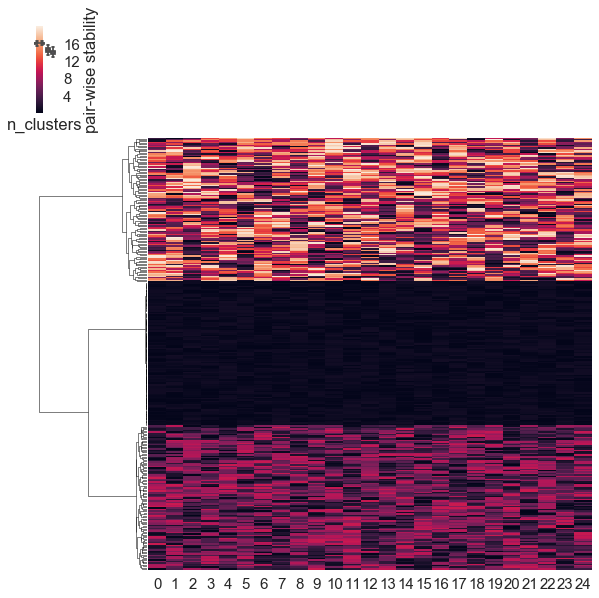

In [138]:
#sim data
n_subs = 100
n_feat = 25
a = np.random.rand(n_subs,n_feat)
b = 10*np.random.rand(n_subs,n_feat)
c = 20*np.random.rand(n_subs,n_feat)
d = np.vstack((a,b,c))
df = pd.DataFrame(data=d)

df['sub'] = range(len(df))
feat_cols = list(range(n_feat))

plot_clusters = False # only plot when you have a single n_clusters value (i.e. not check)
permute = 100

cluster_list = [2,3,4,5]
stab = np.zeros((len(cluster_list),permute))
for n,n_clusters in enumerate(cluster_list):
    df,permute_ci = get_clusters(df,feat_cols,n_clusters,plot_clusters,permute)
    stab[n,:] = permute_ci
    
sns.set(style="white")
sns.set(font_scale=1.5)
sns.boxplot(data=pd.DataFrame(stab.T),orient='v')
plt.xlabel('n_clusters')
plt.ylabel('pair-wise stability')
